## A python script for Kelvin Helmholtz Instability Simulation
Project for class AST 542

Algorithms are adopted form Philip Mocz's lecture

Rui Xu

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Simulation parameters

In [47]:
Nx = 128 # number of grid points in x-direction
Ny = 128 # number of grid points in y-direction
dx = 1.0/Nx # grid size in x-direction
dy = 1.0/Ny # grid size in y-direction
vol = dx*dy # grid volumn
cfl = 0.4  # cfl condition
gamma = 5/3. # adiabatic index
tend, tout = 2, 0.4 # simulation time, output time
Y, X= np.meshgrid(np.linspace(0.5*dy,1-0.5*dy,Ny),
                   np.linspace(0.5*dx, 1-0.5*dx, Nx))

### Initial condition KHI

In [48]:
rho = 1.0 + (np.abs(Y-0.5)<0.25) 
vx = -0.5 + (np.abs(Y-0.5)<0.25)
vy = 0.1*np.sin(4*np.pi*X)
P = 0*X + 2.5 
R, L  = -1, 1 # rightward/leftward for np.roll

In [49]:
# calcualte the gradient of "val" in x and y direction
def cal_grad(val, dx, dy):
    val_x = (np.roll(val,-1,axis=0)-np.roll(val,1,axis=0))/(2.0*dx)
    val_y = (np.roll(val,-1,axis=1)-np.roll(val,1,axis=1))/(2.0*dy)
    return val_x, val_y

In [50]:
# calculate the face value of a parameter
def cal_face_val(tval, val_x, val_y, dx, dy):
    val_xl = np.roll(tval - val_x*dx/2, -1, axis=0)
    val_xr = tval + val_x * dx/2.
    val_yl = np.roll(tval- val_y*dy/2.,-1, axis=1)
    val_yr = tval + val_y*dy/2.0
    return val_xl, val_xr, val_yl, val_yr
    

### Run the simulation

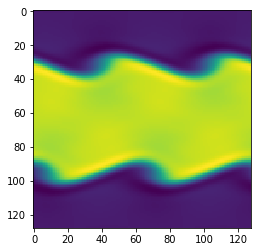

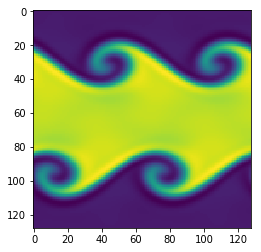

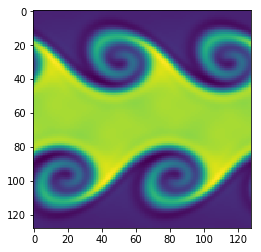

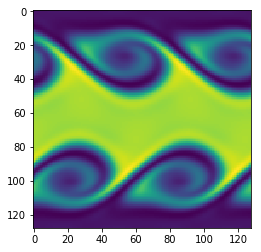

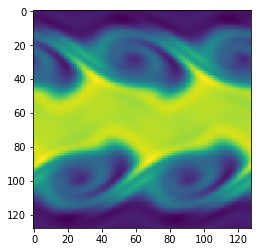

In [51]:
# calculate the conversed variables

Mass = rho * vol
Momx = rho * vx * vol
Momy = rho * vy * vol
Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol


outputCount = 1
# Main loop
t = 0
while (t < tend):
    
    # get primitive variables
    rho = Mass / vol
    vx = Momx / rho / vol
    vy = Momy / rho / vol
    P = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)

    # get time step (CFL)
    dt = cfl * np.min( np.min([dx,dy]) / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)) )

    # calculate gradients
    rho_gradx, rho_grady = cal_grad(rho, dx, dy)
    vx_gradx, vx_grady = cal_grad(vx, dx, dy)
    vy_gradx, vy_grady = cal_grad(vy, dx, dy)
    P_gradx, P_grady = cal_grad(P, dx, dy)

    # extrapolate to cell faces (in time & space)
    rho_prime = rho - 0.5*dt *( vx * rho_gradx + rho * vx_gradx + vy * rho_grady + rho * vy_grady)
    rho_XL, rho_XR, rho_YL, rho_YR = cal_face_val(rho_prime, rho_gradx, rho_grady, dx, dy)

    vx_prime = vx - 0.5*dt * ( vx * vx_gradx + vy * vx_grady + (1/rho) * P_gradx )
    vx_XL, vx_XR, vx_YL, vx_YR = cal_face_val(vx_prime, vx_gradx, vx_grady, dx, dy)

    vy_prime = vy - 0.5*dt * ( vx * vy_gradx + vy * vy_grady + (1/rho) * P_grady )
    vy_XL, vy_XR, vy_YL, vy_YR = cal_face_val(vy_prime, vy_gradx, vy_grady, dx, dy)

    P_prime = P - 0.5*dt * ( gamma*P * (vx_gradx + vy_grady)  + vx * P_gradx + vy * P_grady )
    P_XL, P_XR, P_YL, P_YR = cal_face_val(P_prime, P_gradx, P_grady, dx, dy)


    # compute star (averaged) states
    rho_Xstar = 0.5*(rho_XL + rho_XR)
    rho_Ystar = 0.5*(rho_YL + rho_YR)
    momx_Xstar = 0.5*(rho_XL * vx_XL + rho_XR * vx_XR)
    momx_Ystar = 0.5*(rho_YL * vx_YL + rho_YR * vx_YR)
    momy_Xstar = 0.5*(rho_XL * vy_XL + rho_XR * vy_XR)
    momy_Ystar = 0.5*(rho_YL * vy_YL + rho_YR * vy_YR)
    en_Xstar = 0.5*( P_XL/(gamma-1)+0.5*rho_XL * (vx_XL**2+vy_XL**2) + P_XR/(gamma-1)+0.5*rho_XR * (vx_XR**2+vy_XR**2))
    en_Ystar = 0.5*( P_YL/(gamma-1)+0.5*rho_YL * (vx_YL**2+vy_YL**2) + P_YR/(gamma-1)+0.5*rho_YR * (vx_YR**2+vy_YR**2))

    P_Xstar = (gamma-1)*(en_Xstar-0.5*(momx_Xstar**2+momy_Xstar**2)/rho_Xstar)
    P_Ystar = (gamma-1)*(en_Ystar-0.5*(momx_Ystar**2+momy_Ystar**2)/rho_Ystar)

    # compute fluxes (local Lax-Friedrichs/Rusanov)
    flux_rho_X = momx_Xstar
    flux_rho_Y = momy_Ystar
    flux_momx_X = momx_Xstar**2/rho_Xstar + P_Xstar
    flux_momx_Y = momy_Ystar * momx_Ystar/rho_Ystar
    flux_momy_X = momx_Xstar * momy_Xstar/rho_Xstar
    flux_momy_Y = momy_Ystar**2/rho_Ystar + P_Ystar
    flux_en_X = (en_Xstar+P_Xstar) * momx_Xstar/rho_Xstar
    flux_en_Y = (en_Ystar+P_Ystar) * momy_Ystar/rho_Ystar

    C = np.sqrt(gamma*P_XL/rho_XL) + np.abs(vx_XL)
    C = np.maximum( C, np.sqrt(gamma*P_XR/rho_XR) + np.abs(vx_XR))
    C = np.maximum( C, np.sqrt(gamma*P_YL/rho_YL) + np.abs(vy_YL))
    C = np.maximum( C, np.sqrt(gamma*P_YR/rho_YR) + np.abs(vy_YR))

    flux_rho_X = flux_rho_X - C * 0.5 * (rho_XL - rho_XR)
    flux_rho_Y = flux_rho_Y - C * 0.5 * (rho_YL - rho_YR)
    flux_momx_X = flux_momx_X - C * 0.5 * (rho_XL * vx_XL - rho_XR * vx_XR)
    flux_momx_Y = flux_momx_Y - C * 0.5 * (rho_YL * vx_YL - rho_YR * vx_YR)
    flux_momy_X = flux_momy_X - C * 0.5 * (rho_XL * vy_XL - rho_XR * vy_XR)
    flux_momy_Y = flux_momy_Y - C * 0.5 * (rho_YL * vy_YL - rho_YR * vy_YR)
    flux_en_X = flux_en_X - C * 0.5 * ( P_XL/(gamma-1)+0.5*rho_XL * (vx_XL**2+vy_XL**2) - (P_XR/(gamma-1)+0.5*rho_XR * (vx_XR**2+vy_XR**2)))
    flux_en_Y = flux_en_Y - C * 0.5 * ( P_YL/(gamma-1)+0.5*rho_YL * (vx_YL**2+vy_YL**2) - (P_YR/(gamma-1)+0.5*rho_YR * (vx_YR**2+vy_YR**2)))

    # update solution
    Mass = Mass - dt * dy * flux_rho_X
    Mass = Mass + dt * dy * np.roll(flux_rho_X,L,axis=0)
    Mass = Mass - dt * dx * flux_rho_Y
    Mass = Mass + dt * dx * np.roll(flux_rho_Y,L,axis=1)
    Momx = Momx - dt * dy * flux_momx_X
    Momx = Momx + dt * dy * np.roll(flux_momx_X,L,axis=0)
    Momx = Momx - dt * dx * flux_momx_Y
    Momx = Momx + dt * dx * np.roll(flux_momx_Y,L,axis=1)
    Momy = Momy - dt * dy * flux_momy_X
    Momy = Momy + dt * dy * np.roll(flux_momy_X,L,axis=0)
    Momy = Momy - dt * dx * flux_momy_Y
    Momy = Momy + dt * dx * np.roll(flux_momy_Y,L,axis=1)
    Energy = Energy - dt * dy * flux_en_X
    Energy = Energy + dt * dy * np.roll(flux_en_X,L,axis=0)
    Energy = Energy - dt * dx * flux_en_Y
    Energy = Energy + dt * dx * np.roll(flux_en_Y,L,axis=1)

    # advance time
    t += dt
    if t>outputCount*tout:
        plt.imshow(rho.T)
        plt.pause(0.001)
        outputCount += 1